# Removing week-day effects and reporting delays

In [1]:
# | default_exp model

In [2]:
# | export
import jax.numpy as jnp
import jax.scipy as jsp
import jax
from jax import vmap, jit
import matplotlib.pyplot as plt
import matplotlib as mpl

from isssm.typing import PGSSM, GLSSMState
from jaxtyping import Array, Float

from tensorflow_probability.substrates.jax.distributions import (
    NegativeBinomial as NBinom,
)

In [3]:
mpl.rcParams["figure.figsize"] = (20, 6)
jax.config.update("jax_enable_x64", True)

## States

We consider states $X_t = \left(\log I_{t}, W_t, \dots, W_{t - 5}, q_{1,t}, q_{2,t}, q_{3,t}, q_{4,t}\right)$ with

- $\log I_{t + 1} = \log I_{t} + \log \rho_{t}$
- $\log \rho_{t + 1} = \log \rho_{t} + \varepsilon^{\rho}_{t + 1}$
- $W_{t + 1} = - \sum_{s = 0}^5 W_{t - s} + \varepsilon^W_{t + 1}$ , $\varepsilon^W_{t + 1} \sim \mathcal N(0, \sigma^2_W)$
- $q_{i,t + 1} = q_{i, t} + \varepsilon_{t + 1}^{q,i}$; $i = 1,2,3,4$


Observations are the breakdown of incidences with Meldedatum $t$ into the delays $i = 1, \dots$. Note that on date $t$, $Y_t$ is only partially observed:
$$
Y^i_{t} \sim \operatorname{Pois} \left( p_{i,t}\exp \left( W_{t} + \log I_{t} \right) \right),
$$
for $i = 1,\dots, 4$.

Here 
$$
    p_{i,t} = \frac{\exp \left( q_{i,t} \right)}{\sum_{j = 1}^{4}\exp \left( q_{j,t} \right)}.
$$

We let 
$$
    \begin{align*}
    S_{t} &= B_{t}X_{t} \\
    &= \left( \log I_{t} + \log W_{t} + q_{1, t}, \dots,  \log I_{t} + \log W_{t} + q_{4, t}, q_{1,t}, \dots, q_{4, t}\right)
    \end{align*}
$$

Now 
$$
    Y_{t}^i | S_{t} \sim \operatorname{Pois} \left( \frac{1}{\sum_{j = 1}^4 \exp \left( S^{4 +j}_t \right)}\exp \left( S_{t}^i \right) \right).
$$
Note the following:

- $Y_t^i$ depends on $5$ of the $8$ signals, not just on one, however the observations are still conditionally independent
- $q_t^i$ are only identifiable up to a constant

In [ ]:
# | export
from isssm.typing import PGSSM
import jax.scipy.linalg as jsla
from tensorflow_probability.substrates.jax.distributions import Poisson


def _model(theta, aux):
    # theta on log scale
    s2_log_r, s2_S, s2_q = jnp.exp(theta)
    np1, n_delay = aux
    n = np1 - 1
    m = 2 + 6 + n_delay
    p = n_delay
    l = 2 + n_delay

    # states
    u = jnp.zeros((np1, m))

    A_I_rho = jnp.array([[1.0, 1.0], [0.0, 1.0]])
    A_S = jnp.array(
        [
            [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        ]
    )

    #A_q = jnp.block(
    #    [
    #        [jnp.zeros((n_delay, 6 * n_delay)), jnp.eye(n_delay)],
    #        [jnp.eye(6 * n_delay), jnp.zeros((6 * n_delay, n_delay))],
    #    ]
    #)
    A_q = jnp.eye(n_delay)
    A = jsla.block_diag(A_I_rho, A_S, A_q)
    v = jnp.zeros((np1, p))

    D = jnp.eye(m)[:, jnp.array([1, 2, *jnp.arange(2 + 6, 2 + 6 + n_delay)])]

    Sigma = jnp.diag(jnp.array([s2_log_r, s2_S, *jnp.repeat(s2_q, n_delay)]))

    # initial u negative for q_t,i 
    u0 = jnp.zeros(m).at[8:].set(-5.0)
    u = u.at[0].set(u0)
    # large initial variance, diffuse initialization
    Sigma0 = jsla.block_diag(
        10 * jnp.eye(1),  # log I,
        1 * jnp.eye(1),  # log rho,
        10 * jnp.eye(6),  # log S
        10 * jnp.eye(n_delay),  # q
    )
    
    B = jnp.concatenate(
        [
            jnp.ones((p, 1)),  # log I
            jnp.zeros((p, 1)),  # log rho
            jnp.ones((p, 1)),  # log S_t
            jnp.zeros((p, 5)),  # log S_t-s
            # jnp.eye(p),  # log q_t
            jnp.block(
                [
                    [jnp.eye(n_delay - 1), -jnp.ones((n_delay - 1, 1))],
                    [jnp.zeros((1, n_delay - 1)), jnp.ones((1, 1))],
                ]
            ),
            jnp.zeros((p, 6 * n_delay)),  # log q_t-s
        ],
        axis=1,
    )

    A = jnp.broadcast_to(A, (n, m, m))
    D = jnp.broadcast_to(D, (n, m, l))
    Sigma = jnp.broadcast_to(Sigma, (n, l, l))
    B = jnp.broadcast_to(B, (np1, p, m))

    def poisson_obs(s, xi):
        return Poisson(log_rate=s)

    dist = poisson_obs
    xi = jnp.empty((np1, p))

    return PGSSM(u, A, D, Sigma0, Sigma, v, B, dist, xi)

The `isssm.laplace_approximation` module assumes that $y_{t,i}$ only depends on $\theta_{t,i}$ which is not the case here. To fix this, we monkey-patch both the LA and MEIS.

In [ ]:
from isssm.kalman import kalman, smoothed_signals
from isssm.typing import GLSSM, GLSSMProposal, ConvergenceInformation
from isssm.laplace_approximation import default_link, vvmap, vdiag
from jax.scipy.optimize import minimize
from functools import partial
from isssm.util import converged
from jax import jacfwd, hessian, jacrev
from jax.lax import while_loop
import isssm.laplace_approximation


def _initial_guess(xi_t, y_t, dist, link=default_link):
    result = minimize(
        lambda s_ti: dist(s_ti, xi_t).log_prob(y_t).sum(),
        jnp.atleast_1d(link(y_t)),
        method="BFGS",
    )
    return jnp.squeeze(result.x)


def laplace_approximation(
    y: Float[Array, "n+1 p"],  # observation
    model: PGSSM,
    n_iter: int,  # number of iterations
    log_lik=None,  # log likelihood function
    d_log_lik=None,  # derivative of log likelihood function
    dd_log_lik=None,  # second derivative of log likelihood function
    eps: Float = 1e-5,  # precision of iterations
    link=default_link,  # default link to use in initial guess
) -> tuple[GLSSMProposal, ConvergenceInformation]:
    print("patched")
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    np1, p, m = B.shape

    s_init = vvmap(partial(_initial_guess, dist=dist, link=link))(xi, y)

    def default_log_lik(
        s_t: Float[Array, "p"], xi_t: Float[Array, "p"], y_t: Float[Array, "p'"]
    ):
        return dist(s_t, xi_t).log_prob(y_t).sum()

    if log_lik is None:
        log_lik = default_log_lik

    if d_log_lik is None:
        d_log_lik = jacfwd(log_lik, argnums=0)
    if dd_log_lik is None:
        dd_log_lik = jacrev(d_log_lik, argnums=0)

    vd_log_lik = jit(vmap(d_log_lik))
    vdd_log_lik = jit(vmap(dd_log_lik))

    def _break(val):
        _, i, z, Omega, z_old, Omega_old = val

        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        all_converged = jnp.logical_and(z_converged, Omega_converged)

        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(all_converged, iteration_limit_reached)

    def _iteration(val):
        s, i, z_old, Omega_old, _, _ = val

        grad = vd_log_lik(s, xi, y)
        Gamma = -vdd_log_lik(s, xi, y)
        Omega = jnp.linalg.inv(Gamma)

        z = s + jnp.linalg.solve(Gamma, grad)
        approx_glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

        filtered = kalman(z, approx_glssm)
        s_new = smoothed_signals(filtered, z, approx_glssm)

        return s_new, i + 1, z, Omega, z_old, Omega_old

    empty_z = jnp.empty_like(s_init)
    empty_Omega = jnp.empty((np1, p, p))
    init = (s_init, 0, empty_z, empty_Omega, empty_z, empty_Omega)

    _keep_going = lambda *args: jnp.logical_not(_break(*args))
    _, n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    final_proposal = GLSSMProposal(u, A, D, Sigma0, Sigma, v, B, Omega, z)
    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )
    return final_proposal, information


isssm.laplace_approximation.laplace_approximation = laplace_approximation

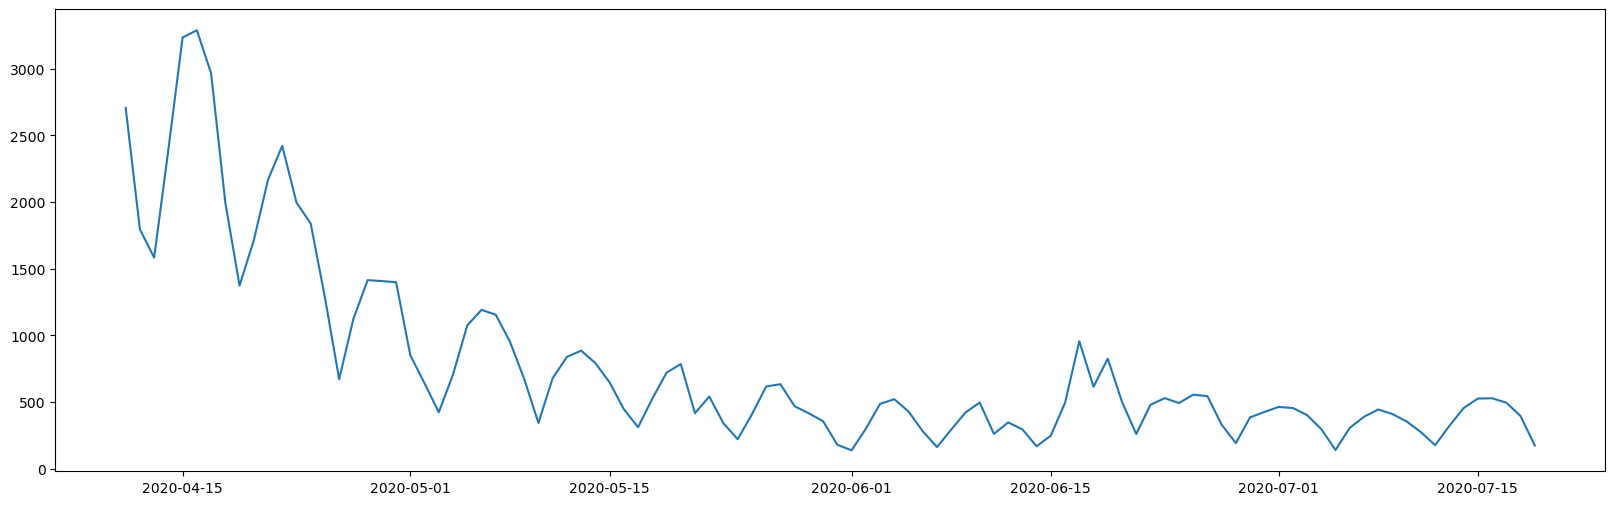

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../../../data/processed/RKI_4day_rt.csv")
n = 100
data_selected = df.iloc[5 : 5 + n, 1:]
dates = pd.to_datetime(df.iloc[5 : 5 + n, 0])
y_t = jnp.asarray(data_selected.to_numpy())

plt.plot(dates, y_t.sum(axis=1))

plt.show()

In [9]:
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
from jax import random as jrn

theta_init = jnp.log(jnp.array([1.0, 1.0, 1.0]))

pgssm = _model(theta_init, (n, 4))

proposal_la, _ = laplace_approximation(y_t, pgssm, 10)
key = jrn.PRNGKey(34234234)
key, subkey = jrn.split(key)
z_meis, omega_meis = MEIS(
    y_t, pgssm, proposal_la.z, proposal_la.Omega, 10, int(1e4), subkey
)

key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y_t, pgssm, z_meis, omega_meis, 10000, subkey
)

ess_pct(log_weights)

patched


Array(7.04784709, dtype=float64)

In [9]:
from isssm.estimation import mle_pgssm, initial_theta

theta0 = initial_theta(y_t, _model, theta_init, (n, 4), 10)

patched


In [10]:
theta0

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 5.920581907612033
        x: [-4.450e+00 -2.063e+00 -3.894e-01]
      nit: 20
      jac: [-8.345e-07 -1.252e-06 -1.788e-06]
 hess_inv: [[ 1.382e+02 -1.981e+01  1.505e-02]
            [-1.981e+01  3.788e+01  2.152e-01]
            [ 1.505e-02  2.152e-01  4.708e+00]]
     nfev: 92
     njev: 23

In [11]:
key, subkey = jrn.split(key)
mle_result = mle_pgssm(y_t, _model, theta0.x, (n, 4), 10, int(1e4), subkey)
mle_result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 5.91866450837086
        x: [-4.450e+00 -2.063e+00 -3.894e-01]
      nit: 1
      jac: [-1.645e-01  4.405e-02 -9.536e-02]
 hess_inv: [[ 1.137e+00 -6.695e-02  1.040e-01]
            [-6.695e-02  3.746e-01  4.808e-01]
            [ 1.040e-01  4.808e-01  6.494e-01]]
     nfev: 137
     njev: 33

In [12]:
theta = theta0.x

fitted_model = _model(theta, (n, 4))

key, subkey = jrn.split(key)
propsal_la, _ = LA(y_t, fitted_model, 10)

z_meis, omega_meis = MEIS(
    y_t, fitted_model, propsal_la.z, propsal_la.Omega, 10, int(1e4), subkey
)

key, subkey = jrn.split(key)
samples, log_weights = pgssm_importance_sampling(
    y_t, fitted_model, z_meis, omega_meis, 10000, subkey
)
ess_pct(log_weights)

Array(18.90000966, dtype=float64)

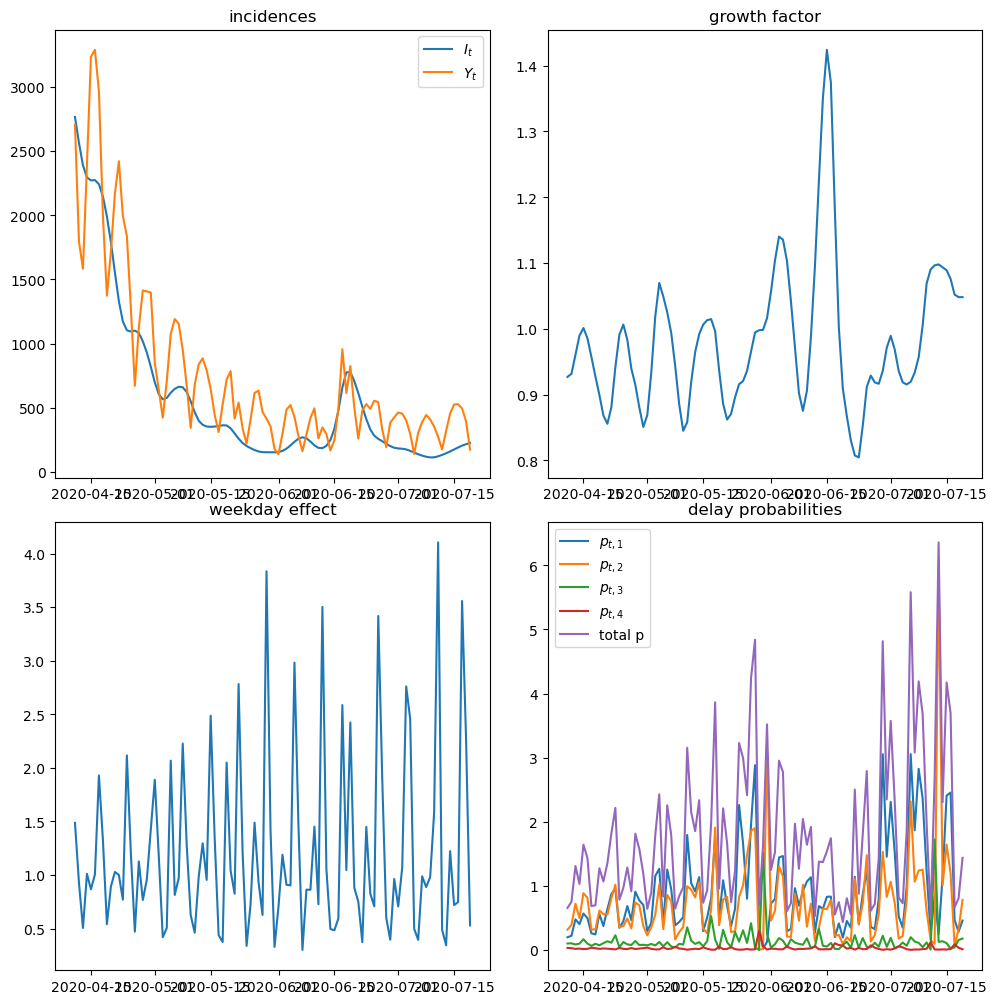

In [40]:
from isssm.importance_sampling import normalize_weights
from isssm.typing import GLSSM
from isssm.kalman import kalman, smoother
from isssm.util import mm_time

signal_model = GLSSM(
    fitted_model.u,
    fitted_model.A,
    fitted_model.D,
    fitted_model.Sigma0,
    fitted_model.Sigma,
    fitted_model.v,
    fitted_model.B,
    jnp.zeros((n, 4, 4)),
)


def smooth_x(sample):
    return smoother(kalman(sample, signal_model), signal_model.A).x_smooth


x_smooth = (
    vmap(smooth_x)(samples) * normalize_weights(log_weights)[:, None, None]
).sum(axis=0)

# plt.plot(jnp.exp(x_smooth[:, 12]), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 2:8].sum(axis=1)), label="smoothed")
# plt.plot(jnp.exp(x_smooth[:, 0]), label="smoothed")
# plt.plot(y.sum(axis=1), label="Y")
# plt.plot(jnp.exp(x_smooth[:, 1]), label="smoothed")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs = axs.flatten()
fig.tight_layout()

axs[0].set_title("incidences")
axs[0].plot(dates, jnp.exp(x_smooth[:, 0]), label="$I_t$")
axs[0].plot(dates, y_t.sum(axis=1), label="$Y_t$")
axs[0].legend()

axs[1].set_title("growth factor")
axs[1].plot(dates, jnp.exp(x_smooth[:, 1]), label="$\\rho_t$")

axs[2].set_title("weekday effect")
axs[2].plot(dates, jnp.exp(x_smooth[:, 2]), label="$S_t$")

axs[3].set_title("delay probabilities")

log_probs = mm_time(fitted_model.B[:, :, 8:12], x_smooth[:, 8:12])
axs[3].plot(dates, jnp.exp(log_probs[:, 0]), label="$p_{t, 1}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 1]), label="$p_{t, 2}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 2]), label="$p_{t, 3}$")
axs[3].plot(dates, jnp.exp(log_probs[:, 3]), label="$p_{t, 4}$")
axs[3].plot(dates, jnp.exp(log_probs).sum(axis=1), label="total p")
axs[3].legend()
plt.show()

In [39]:
fitted_model.B[0, :, 8:12]

Array([[ 1.,  0.,  0., -1.],
       [ 0.,  1.,  0., -1.],
       [ 0.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  1.]], dtype=float64)

In [ ]:
from nbdev import export

export.nb_export("10_model.ipynb", "src")